In [1]:
!pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
import torch
import math

from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,attn2map
from ithor_tools.map import single_scenemap
from grad_cam.cam import clip_grad_cam
from FBE.fbe import gridmap
from ai2thor.util.metrics import get_shortest_path_to_object
from ithor_tools.utils import check_vis,step_local_search
# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing
from FBE.step import step_frontier

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_gradcam = clip_grad_cam(device)

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [3]:
gridSize=0.05
scene_name = "FloorPlan_Train8_1"
controller = Controller(
    platform=CloudRendering,
    agentMode="locobot",
    visibilityDistance=2.0,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    width=300,
    height=300,
    fieldOfView=90
)

controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)



INFO - 2022-06-04 22:21:12,423 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


<ai2thor.server.Event at 0x7f1bd266f940
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [4]:
objects = controller.last_event.metadata['objects']
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Plate,Plate|+01.86|+00.73|-01.18,Plate_26,1.8645,0.7321,-1.1818,359.8788,16.2492,359.9527,3.6444,...,0.0,True,False,False,0.62,[Ceramic],Plate_26,[SideTable|+01.59|+00.00|-01.17],None,False
1,Bottle,Bottle|+05.66|+00.54|-02.50,Bottle_1,5.6640,0.5446,-2.4960,359.9635,359.9903,359.9713,3.6314,...,0.0,True,False,False,0.20,[Glass],Bottle_1,[CoffeeTable|+05.45|+00.00|-02.95],None,False
2,HousePlant,HousePlant|+05.42|+00.55|-02.95,Houseplant_6,5.4193,0.5468,-2.9490,0.0491,0.0521,359.8313,3.1705,...,0.0,False,False,True,3.00,"[Ceramic, Organic]",Houseplant_6,[CoffeeTable|+05.45|+00.00|-02.95],None,True
3,Apple,Apple|+05.38|+00.61|-03.39,Apple_6,5.3818,0.6092,-3.3868,310.4288,307.2215,267.1519,2.9112,...,0.0,True,False,False,0.20,[Food],Apple_6,[CoffeeTable|+05.45|+00.00|-02.95],None,True
4,Bowl,Bowl|+05.66|+00.54|-03.35,Bowl_6,5.6636,0.5450,-3.3521,0.0019,359.9758,0.0094,3.1850,...,0.0,True,False,False,0.47,[Ceramic],Bowl_6,[CoffeeTable|+05.45|+00.00|-02.95],None,True
5,BasketBall,BasketBall|+07.12|+00.17|-01.90,Basketball_1,7.1227,0.1660,-1.9024,7.9563,286.2621,91.9585,5.2012,...,0.0,True,False,False,0.60,[Rubber],Basketball_1,"[ShelvingUnit|+07.10|+00.00|-01.96, Floor|+00....",None,True
6,AlarmClock,AlarmClock|+01.31|+00.48|-04.01,Alarm_Clock_6,1.3060,0.4778,-4.0129,0.0043,74.9883,0.0133,1.6980,...,0.0,True,False,False,0.80,"[Metal, Plastic, Glass]",Alarm_Clock_6,"[SideTable|+01.21|+00.00|-04.25, Floor|+00.00|...",None,True
7,Television,Television|+09.53|+00.96|-03.10,Television_6,9.5309,0.9628,-3.1030,0.1047,269.9915,0.0799,6.9180,...,0.0,False,False,True,9.83,"[Plastic, Metal]",Television_6,"[SideTable|+09.60|+00.00|-03.08, Floor|+00.00|...",[],True
8,RemoteControl,RemoteControl|+01.15|+00.48|-04.24,Remote_3,1.1509,0.4773,-4.2404,0.0190,345.4326,359.9791,1.7636,...,0.0,True,False,False,0.15,"[Metal, Plastic]",Remote_3,"[SideTable|+01.21|+00.00|-04.25, Floor|+00.00|...",None,True
9,TennisRacket,TennisRacket|+03.73|+00.50|-02.84,Tennis_Racket_3,3.7316,0.4987,-2.8409,88.3348,175.5801,161.8795,2.1180,...,0.0,True,False,False,0.31,"[Metal, Plastic]",Tennis_Racquet_3,"[CoffeeTable|+03.44|00.00|-02.69, Floor|+00.00...",None,True


In [5]:
query_object_index = 3
query_object = objects[query_object_index]
pos = controller.last_event.metadata['agent']['position']
try:
    min_path = get_shortest_path_to_object(controller,query_object['objectId'],pos)
    min_length = 0
    last_pos = pos
    for p in min_path:
        min_length += math.sqrt((last_pos['x']-p['x'])**2+(last_pos['z']-p['z'])**2)
        last_pos = p
except:
    min_length = 0.1

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
(98, 59)
(418, 713, 4)


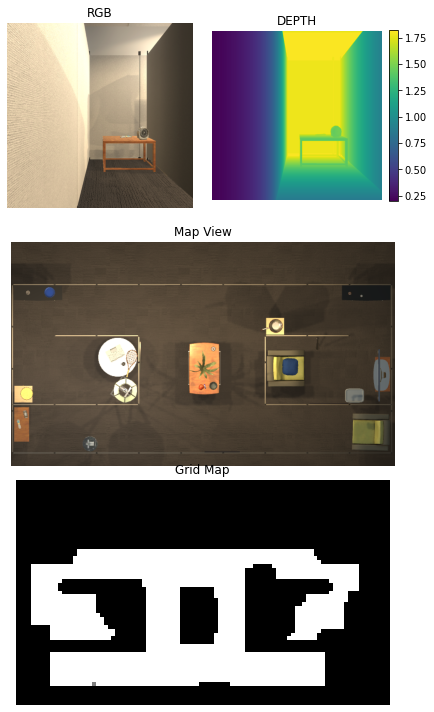

In [6]:
controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)

scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1)

pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

In [7]:
proj = attn2map(controller,sm.gridmap)
fbe = gridmap(controller,scene_bounds,clip_gradcam,proj,sm)
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789


In [8]:
controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
        )

pos = controller.last_event.metadata['agent']['position']
try:
    min_path = get_shortest_path_to_object(controller,query_object['objectId'],pos)
    min_length = 0
    last_pos = pos
    for p in min_path:
        min_length += math.sqrt((last_pos['x']-p['x'])**2+(last_pos['z']-p['z'])**2)
        last_pos = p
except:
    min_length = 0.1

In [9]:
query_object_name = query_object['objectType']

new_query_object_name = ''
if len(query_object_name)>2:
    for i, letter in enumerate(query_object_name):
        if i and letter.isupper():
            new_query_object_name += ' '
        new_query_object_name += letter.lower()
else:
    new_query_object_name = query_object_name
clip_gradcam.set_text(new_query_object_name)
print(new_query_object_name)

apple


/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[{'x': 4.5, 'y': 0.91, 'z': -4.000000000000001}]
start planning


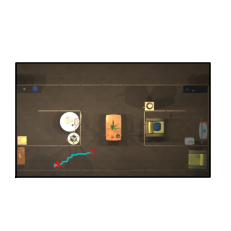

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


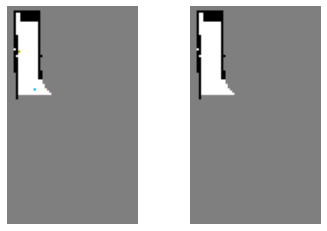

[{'x': 4.5, 'y': 0.91, 'z': -2.3000000000000007}, {'x': 6.2, 'y': 0.91, 'z': -4.1000000000000005}]
start planning


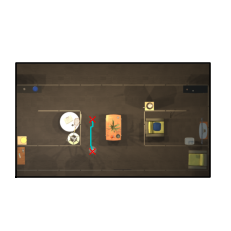

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


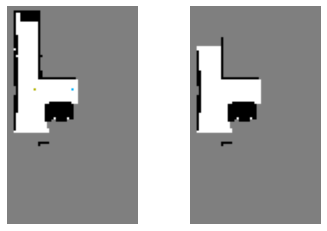

[{'x': 2.9000000000000004, 'y': 0.91, 'z': -1.6000000000000005}, {'x': 6.2, 'y': 0.91, 'z': -1.7000000000000006}, {'x': 6.2, 'y': 0.91, 'z': -4.1000000000000005}]
start planning


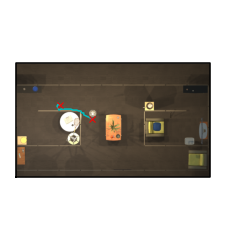

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


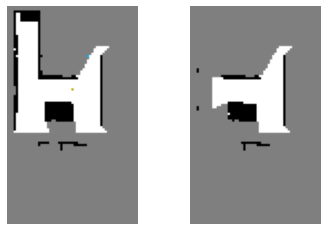

[{'x': 1.2000000000000002, 'y': 0.91, 'z': -2.5000000000000004}, {'x': 6.2, 'y': 0.91, 'z': -1.7000000000000006}, {'x': 6.2, 'y': 0.91, 'z': -4.1000000000000005}]
start planning


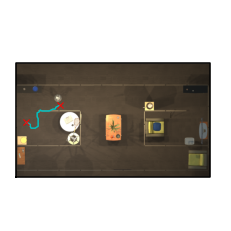

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


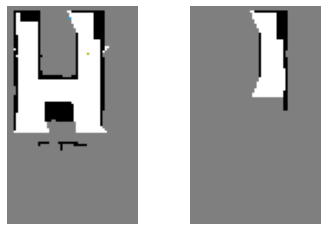

[{'x': 6.2, 'y': 0.91, 'z': -1.7000000000000006}, {'x': 6.2, 'y': 0.91, 'z': -4.1000000000000005}, {'x': 9.6, 'y': 0.91, 'z': -3.7000000000000006}, {'x': 9.7, 'y': 0.91, 'z': -4.000000000000001}]
start planning


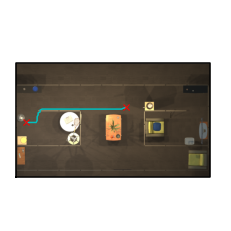

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


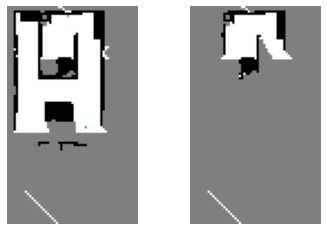

[{'x': 6.300000000000001, 'y': 0.91, 'z': -4.300000000000001}, {'x': 7.800000000000001, 'y': 0.91, 'z': -1.6000000000000005}, {'x': 9.6, 'y': 0.91, 'z': -3.7000000000000006}, {'x': 9.7, 'y': 0.91, 'z': -4.000000000000001}]
start planning


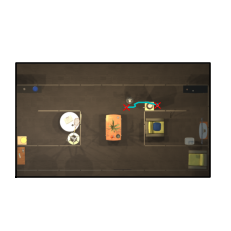

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


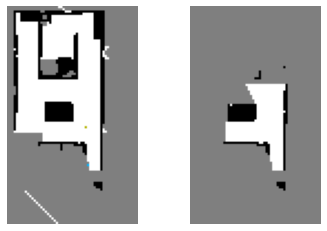

[{'x': 6.300000000000001, 'y': 0.91, 'z': -4.300000000000001}, {'x': 9.6, 'y': 0.91, 'z': -3.7000000000000006}, {'x': 9.7, 'y': 0.91, 'z': -4.000000000000001}]
start planning


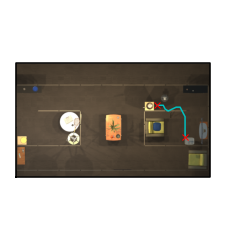

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


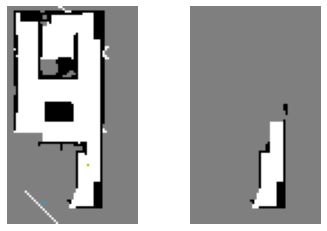

[{'x': 6.300000000000001, 'y': 0.91, 'z': -4.300000000000001}]
start planning


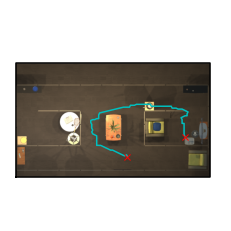

/home/jeongeun/.pyenv/versions/3.8.8/envs/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

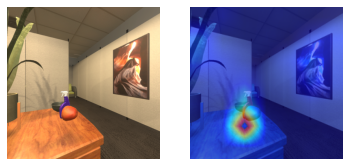

0.03583302500158257


In [10]:
gt_find = False
total_path_len = 0
while gt_find != True:
    gt_find,sucess,path_len, reset_map  = step_frontier(fbe,rrtplanner,controller,query_object,clip_gradcam=clip_gradcam,vis=True,verbose=True)
    total_path_len += path_len
    if reset_map:
        proj.reset()
        fbe.reset()
    if total_path_len>50:
        break
SPL = sucess*min_length/total_path_len
print(SPL)